# Pre-Processing Workflow
As a rule, if any pre-processing is to be done on the samples I prefer to do it prior to training and to store the pre-processed data separately. For a fully trained model it is better to run the transformers in the normal manner, but during training it adds unnecessarily to runtime, as the pre-processing is applied every epoch.

Still, this creates some inflexibility, as tuning the pre-processing steps becomes far more tedious.

Generally my solution is to run hyper-parameter tuning on a small batch of the data using a toy model, evaluate that model's success via cross-validation, and then use those values to pre-process the entire dataset.

Obviously even the above would be useless without a general sense of what techniques should be applied to what kinds of data.

In [6]:
%load_ext autoreload
%autoreload 2
import sys; sys.path.append('./*'); sys.path.append('..')

import torch
import torch.nn as nn
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from os import path
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from sklearn.model_selection import train_test_split
from trainer import Trainer
import pandas as pd
import numpy as np
import sklearn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

d = '../../../../ml_data/metal_sheet_data'

from datasets.ClassificationSet import ClassificationSet
from models.SheetClassifier import SheetClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def stratified_ds_split(df:pd.DataFrame, dataset_class:type, target_column_names:list, reporting:bool = False) -> tuple:
  ''' Stratifies the dataset by the given list of target columns, attempting to ensure consistent distribution of classes therein.
      Allows for multiple columns to form the strata key (so if you want to group by age, sex, and whatever else, you can).
  '''

  # Ensures consistent distribution of the given classes
  if len(target_column_names) == 1: stratification_key = target_column_names[0]
  else:
    stratification_key = 'strat_key'
    df[stratification_key] = df[target_column_names].astype(str).sum(axis=1)

  # Split the complete df into training and test
  training_features, testing_features, training_targets, testing_targets = train_test_split(df, df[stratification_key], test_size=0.2, stratify=df[stratification_key])

  # Generate weights for the classes based on their representation in the target series
  target = np.array(training_features[stratification_key])
  target_classes = np.unique(target)
  weights = {t: len(np.where(target == t)[0])/len(training_features) for t in target_classes}

  if reporting:
    whole_df_target = np.array(df[stratification_key])
    whole_df_weights = {t: len(np.where(whole_df_target == t)[0])/len(df) for t in target_classes}
    print('Our target classes are as follows:',target_classes,'\n','-'*50,
                      '\nTheir representation in the dataset as a whole are:\n',{str(item[0]):round(float(item[1]),5) for item in whole_df_weights.items()},
                      '\nTheir representation in our training dataloader are:\n',{str(item[0]):round(float(item[1]),5) for item in weights.items()})

  weights_to_samples = np.array([weights[target[row_i]] for row_i in range(len(target))])
  weights_to_samples = torch.from_numpy(weights_to_samples)
  training_sampler = WeightedRandomSampler(weights_to_samples, len(weights_to_samples))

  return dataset_class(training_features), dataset_class(testing_features), training_sampler

In [72]:
# Load the dataset
full_data = pd.read_csv(f'{path.join(d, 'training_set')}/metadata.csv')
dummy_parameters = SheetClassifier().state_dict()
trainer = Trainer()

# from sklearn.model_selection import StratifiedShuffleSplit would have given us the same distrobution as the original
train_set, test_set, y_train, y_test = train_test_split(full_data, full_data.target, train_size=.1, test_size=0.1, random_state=0, stratify=full_data.target)
train_set['target'] = y_train; test_set['target'] = y_test

# Show levels of targets are equivalent
print('Bubbles to Line in Training',round(len(y_train[y_train == 1])/len(y_train[y_train == 2]),2))
print('Bubbles to Line in Training',round(len(y_test[y_test == 1])/len(y_test[y_test == 2]),2))

Bubbles to Line in Training 1.01
Bubbles to Line in Training 1.0


In [81]:
def test_parameters(results:pd.DataFrame, blur_value, norm_mean, norm_std, train_set, test_set, epochs, show=False):
    transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(blur_value),
                v2.Normalize([norm_mean], [norm_std], inplace=True),
                ]
            )
    c_train = ClassificationSet(path.join(d, 'training_set'), train_set, transform)
    c_test = ClassificationSet(path.join(d, 'training_set'), test_set, transform)
    temp_model = SheetClassifier()
    temp_model.load_state_dict(dummy_parameters)
    trainer.run_experiment(temp_model, c_train, c_test, criterion=nn.CrossEntropyLoss, epochs=epochs, show=show, train_shuffle=False, test_shuffle=False)

    ''' It is absolutely essential that we set the initial parameters of the model to be the same each time, or else
        this technique would be subject to randomness.
    '''
    trainer.evaluate_model(temp_model, show=False)
    results.loc[len(results)] = [blur_value, norm_mean, norm_std, trainer.model_accuracy, trainer.model_loss]


In [82]:
ideal_compose, model_score = None, 0

results = pd.DataFrame([], columns=['blur_value', 'norm_mean', 'norm_std', 'accuracy', 'loss'])
for blur_value in [1, 3, 5]:
    for norm_mean in [-.5, 0., .5]:
        for norm_std in [.01, .1, .25]:
            print('blur_value:',blur_value, 'norm_mean:',norm_mean, 'norm_std:', norm_std)
            test_parameters(results, blur_value, norm_mean, norm_std, train_set, test_set, 25)
            print(results)

blur_value: 1 norm_mean: -0.5 norm_std: 0.01
   blur_value  norm_mean  norm_std        accuracy      loss
0           1       -0.5      0.01  tensor(0.6620)  2.680267
blur_value: 1 norm_mean: -0.5 norm_std: 0.1
   blur_value  norm_mean  norm_std        accuracy      loss
0           1       -0.5      0.01  tensor(0.6620)  2.680267
1           1       -0.5      0.10  tensor(0.6740)  2.524463
blur_value: 1 norm_mean: -0.5 norm_std: 0.25
   blur_value  norm_mean  norm_std        accuracy      loss
0           1       -0.5      0.01  tensor(0.6620)  2.680267
1           1       -0.5      0.10  tensor(0.6740)  2.524463
2           1       -0.5      0.25  tensor(0.6800)  2.367135
blur_value: 1 norm_mean: 0.0 norm_std: 0.01
   blur_value  norm_mean  norm_std        accuracy      loss
0           1       -0.5      0.01  tensor(0.6620)  2.680267
1           1       -0.5      0.10  tensor(0.6740)  2.524463
2           1       -0.5      0.25  tensor(0.6800)  2.367135
3           1        0.0     

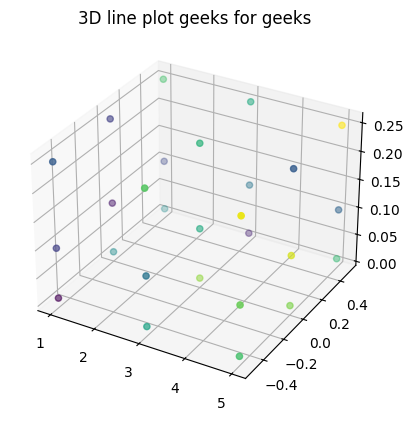

Best Performers     blur_value  norm_mean  norm_std        accuracy      loss
26           5        0.5      0.25  tensor(0.7240)  4.323346
20           5       -0.5      0.25  tensor(0.7220)  4.675774
22           5        0.0      0.10  tensor(0.7200)  5.781259 

Worst Performers     blur_value  norm_mean  norm_std        accuracy      loss
0            1       -0.5      0.01  tensor(0.6620)  2.680267
4            1        0.0      0.10  tensor(0.6660)  2.543433
15           3        0.5      0.01  tensor(0.6680)  4.966142


In [83]:
# importing mplot3d toolkits, numpy and matplotlib
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
 
# plotting
ax.scatter(results.blur_value, results.norm_mean, results.norm_std, c=results.accuracy)
ax.set_title('3D line plot geeks for geeks')
plt.show()

best = results.sort_values('accuracy')[::-1][:3]
worst = results.sort_values('accuracy')[:3]
print('Best Performers',best,'\n\nWorst Performers',worst)

In [84]:
eval_train_set, eval_test_set, y_train, y_test = train_test_split(full_data, full_data.target, train_size=.8, random_state=0, stratify=full_data.target)
eval_train_set['target'] = y_train; eval_test_set['target'] = y_test

In [85]:
best_values = pd.DataFrame([], columns=['blur_value', 'norm_mean', 'norm_std', 'accuracy', 'loss'])
for idx in best.index[:1]:
    entry = best.loc[idx]
    test_parameters(best_values, entry.blur_value, entry.norm_mean, entry.norm_std, eval_train_set, eval_test_set, 10, show=True)
best_values

Epoch [1/10], Train Loss: 4.92, Accuracy: 0.63
Experiment Complete


,blur_value,norm_mean,norm_std,accuracy,loss
0,5,0.5,0.25,tensor(0.8410),0.468255


In [86]:
worst_values = pd.DataFrame([], columns=['blur_value', 'norm_mean', 'norm_std', 'accuracy', 'loss'])
for idx in worst.index[:1]:
    entry = worst.loc[idx]
    test_parameters(worst_values, entry.blur_value, entry.norm_mean, entry.norm_std, eval_train_set, eval_test_set, 10, show=True)
worst_values

Epoch [1/10], Train Loss: 3.34, Accuracy: 0.65
Experiment Complete


,blur_value,norm_mean,norm_std,accuracy,loss
0,1,-0.5,0.01,tensor(0.7800),0.989971


Note, it looks like the lowest values tended to have the least blur, and further, that those parameters did well in the training but poorely in testing, this is a classic example of overfitting, and another reason why this much care in the pre-processing phase *matters*.

## Apply the Best Transformer to the Data as a Pre-processing Step

In [120]:
transfer_dir = '../../../ml_data/metal_sheet_data/preprocessed_training_set'
entry = best_values.iloc[0]
transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(entry.blur_value),
                v2.Normalize([entry.norm_mean], [entry.norm_std], inplace=True)
                ])
preprocess_set = ClassificationSet(path.join(d, 'training_set'), transform=transform)
preprocess_set.transform_pass('../../../ml_data/metal_sheet_data/preprocessed_training_set')

## Test the Speed of Training Between Preprocessed and On Call Processed

In [123]:
dpre_processed = '../../../ml_data/metal_sheet_data/preprocessed_training_set'
model = SheetClassifier()
model.load_state_dict(dummy_parameters)

transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(entry.blur_value),
                v2.Normalize([entry.norm_mean], [entry.norm_std], inplace=True)
                ])
normal_set = ClassificationSet(path.join(d, 'training_set'), transform=transform)
preprocessed_dataset = ClassificationSet(dpre_processed))



(Image([[[251.3262, 246.2563, 228.6832,  ..., 198.1450, 155.3611, 140.0581],
         [239.8032, 234.9885, 219.4305,  ..., 191.8659, 151.9844, 138.3320],
         [214.4600, 211.9127, 205.8382,  ..., 194.9640, 166.8434, 157.6936],
         ...,
         [194.7603, 183.2986, 156.7536,  ..., 237.5763, 212.3495, 202.3412],
         [223.4107, 210.4141, 176.3115,  ..., 250.1866, 250.9385, 252.4061],
         [236.4339, 225.0464, 192.7118,  ..., 247.7881, 262.6575, 270.0618]]], ),
 np.int64(0))

In [124]:
trainer.evaluate_model(model, DataLoader(normal_set, 10))

[Evaluation over 500 Batches], Test Loss: 9.63, Accuracy: 0.29


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

In [125]:
trainer.evaluate_model(model, DataLoader(preprocessed_dataset, 10))

[Evaluation over 500 Batches], Test Loss: 7.41, Accuracy: 0.33


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

## Results
As we can see, using the pre-processed dataset takes 15% of the time of the non-preprocessed set, and as shown above.